# FINM 35700 - Spring 2023

## Final exam: May 23 2023 - from 6pm to 8:45pm

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on following symbology & data files, as of 2023-05-19.

US government bonds:
- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,

Corporate bonds:
- the corporate  bonds symbology file (LQD constituents + AT&T bonds) `corp_symbology`
- the LQD ETF basket composition file `lqd_basket_composition`
- AT&T bond portfolio notionals: `att_bond_portoflio`

Market data:
- the cash bond market data file (US Treasuries + AT&T bonds) `market_prices_eod`,


## Scoring: Total of 125 points

| Problem | Points |
|---------|--------|
| 1       | 20     |
| 2       | 20     |
| 3       | 30     |
| 4       | 30     |
| 5       | 25     |
| Total   | 125    |

-----------------------------------------------------------------------------------------
# Collection of useful calibration helper functions from previous homeworks

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date):
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve


def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''        
    if(maturity == 0 or params[3] <= 0):
        slope_1 = 1
        curvature = 0
    else:
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
        curvature = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature
    
    return total_value

def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''            
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]
    
    # cap and floor survival probs
    nelson_siegel_surv_prob_levels = [max(min(x,1),1e-8) for x in nelson_siegel_surv_prob_levels]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)
    
    return(nelson_siegel_credit_curve_handle)


def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # nelson_siegel_surv_prob_curve_handle
    nelson_siegel_surv_prob_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    
    # nelson_siegel_risky_bond_engine
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_surv_prob_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    
    bond_model_prices = []
    bond_model_yields = []
    
    for fixed_rate_bond in fixed_rate_bond_objects:
        fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
        
        bond_price = fixed_rate_bond.cleanPrice()                
        bond_yield = fixed_rate_bond.bondYield(bond_price, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100
        
        bond_model_prices.append(bond_price)
        bond_model_yields.append(bond_yield)
    
    return(bond_model_prices, bond_model_yields)

def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # bond_model_prices
    bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
    # sse    
    sse = 0
    
    for i in range(len(market_prices)):
        model_error = market_prices[i] - bond_model_prices[i]                
        sse += abs(model_error) * calib_weights[i]                        
    
    return(sse)    


def create_bonds_and_weights(bond_details, tsy_yield_curve_handle):
    
    # risk_free_bond_engine
    risk_free_bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)


    fixed_rate_bond_objects = []
    bond_market_prices = []    
    bond_yields = []
    bond_DV01s = []    
    bond_durations = []    
    
    for index,row in bond_details.iterrows():
        fixed_rate_bond = create_bond_from_symbology(row)
        fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
        
        fixed_rate_bond_objects.append(fixed_rate_bond)
        
        bond_price = row['market_price']                
        bond_yield = fixed_rate_bond.bondYield(bond_price, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100
        bond_yield_rate = ql.InterestRate(bond_yield/100, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
        bond_duration = ql.BondFunctions.duration(fixed_rate_bond, bond_yield_rate)
        bond_DV01   = fixed_rate_bond.dirtyPrice() * bond_duration
        
        bond_market_prices.append(bond_price)
        bond_yields.append(bond_yield)
        bond_DV01s.append(bond_DV01)
        bond_durations.append(bond_duration)   
        
    # calib_weights: down-weight durations < 2 years, since the calibrated US treasury does not have quotes before 2Y
    calib_weights = [1 / max(d, 2) for d in bond_durations]
    sum_calib_weights = sum(calib_weights)
    calib_weights = [x / sum_calib_weights for x in calib_weights]
    
    return(fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations)


def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    # create_bonds_and_weights
    fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(bond_details, tsy_yield_curve_handle)
    
    # start calibration
    param_bounds = [(1e-3, 0.1), (-0.1, 0.1), (-0.1, 0.1), (1e-3, 10)]
            
    calib_results = minimize(nelson_siegel_sse,
                                            initial_nelson_siegel_params, 
                                            args = (calc_date, 
                                                    fixed_rate_bond_objects, 
                                                    bond_market_prices, 
                                                    calib_weights,
                                                    tsy_yield_curve_handle, 
                                                    bond_recovery_rate),
                                            bounds = param_bounds)


    return(calib_results)



------------------------------------------------------------
# Problem 1: Overall understanding of credit market models (20 points)
## When answering the individual questions, you should assume 'ceteris paribus' - all else being equal.

## a. Fixed rate bond prices in the hazard rate model: True or False (5 points)

### - Use flat hazard rate model formula [54] in Lecture 4 to confirm your intuition - 

1. Fixed rate bond price is increasing in interest rate
    - False, the opposite is true.
2. Fixed rate bond price is increasing in hazard rate
    - False, the opposite is true.
3. Fixed rate bond price is increasing in expected recovery rate
    - True, since the value of the recovery leg goes up.
4. Fixed rate bond price is increasing in coupon
    - True, since the value of the premium leg goes up.
5. Fixed rate bond price is increasing in bond maturity
    - False - this is only the case when the contractual coupon is higher than the bond yield.

## b. Fixed rate bond yields in the hazard rate model: True or False (5 points)

1. Fixed rate bond yield is increasing in interest rate
    - True, since "bond_yield ~ interest_rate + hazard_rate * (1 - recovery)".
2. Fixed rate bond yield is increasing in hazard rate
    - True, since "bond_yield ~ interest_rate + hazard_rate * (1 - recovery)".
3. Fixed rate bond yield is increasing in expected recovery rate
    - False, the opposite is true.
4. Fixed rate bond yield is increasing in coupon
    - False, this is not always the case.
5. Fixed rate bond yield is increasing in bond maturity
    - False, this is only the case for upward sloping yield curves.

## c. Equity and equity volatility in the Merton Structural Credit Model: True or False (5 points)

### - Think about the equity value as a "call option on assets with liabilities as strike" -

1. Equity value is increasing with company assets
    - True, the call option has positive delta.
2. Equity volatility is increasing with company assets
    - False, the opposite is true, as shown in Homework 4, Problem 4.d.
3. Equity value is increasing with assets volatility
    - True, since the call option vega is positive
4. Equity value is increasing with company liabilities
    - False, the opposite is true.
5. Equity volatility is increasing with company liabilities
    - True, similar argument to Homework 4, Problem 4.d


## d. Yield and expected recovery rate in the Merton Structural Credit Model: True or False (5 points)

1. Yield is increasing with company liabilities
    - True, the company becomes "riskier" with higher liabilities.
2. Expected recovery rate is increasing with company liabilities
    - False, the opposite is the case.
3. Yield is increasing with assets volatility
    - True, the company becomes "riskier" with higher liabilities.
4. Credit spread is increasing with asset values
    - False, the opposite is true.
5. Credit spread is increasing with assets volatility
    - True, the company becomes "riskier" with higher assets volatility.
    


-----------------------------------------------------------
# Problem 2: Scenario analysis for a fixed rate corporate bond (yield model) (20 points)
## Use the QuantLib Introductory notebook (or any of the homeworks) as a template.

## a. Create generic fixed-rate corporate bond (5 points)
Fix the calculation date as of May 19 2023 (last Friday) and use a coupon of 5% and a maturity of 10 years (May 19 2033).

Display the fixed rate bond cashflows.

In [3]:
# Use static calculation/valuation date of 2023-05-19, matching data available in the market prices EOD file
calc_date = ql.Date(19, 5, 2023)
ql.Settings.instance().evaluationDate = calc_date

# used to identify calc date in market data frames
calc_date_str = '2023-05-19'

In [4]:
# bond_details
test_bond_details = {'start_date': '2023-05-19', 
                'acc_first': '2023-05-19', 
                'maturity': '2033-05-19', 
                'coupon': 5,
                'dcc' : '30/360',
                'days_settle' : 2}

# Use create_bond_from_symbology() to create the bond
test_fixed_rate_bond = create_bond_from_symbology(test_bond_details)

test_fixed_rate_bond_cashflows_df = get_bond_cashflows(test_fixed_rate_bond, calc_date)
print(test_fixed_rate_bond_cashflows_df)

           CashFlowDate  CashFlowYearFrac  CashFlowAmount
0   November 19th, 2023               0.5             2.5
1        May 19th, 2024               1.0             2.5
2   November 19th, 2024               1.5             2.5
3        May 19th, 2025               2.0             2.5
4   November 19th, 2025               2.5             2.5
5        May 19th, 2026               3.0             2.5
6   November 19th, 2026               3.5             2.5
7        May 19th, 2027               4.0             2.5
8   November 19th, 2027               4.5             2.5
9        May 19th, 2028               5.0             2.5
10  November 19th, 2028               5.5             2.5
11       May 19th, 2029               6.0             2.5
12  November 19th, 2029               6.5             2.5
13       May 19th, 2030               7.0             2.5
14  November 19th, 2030               7.5             2.5
15       May 19th, 2031               8.0             2.5
16  November 1

## b. Compute the bond price, DV01, duration and convexity (analytic method). (5 points)

The market yield of the bond is 6%. Compute the bond price, DV01, duration and convexity, using the analytic method.

In [5]:
# test_bond_yield of 6%
test_bond_yield = 6

# test_bond_clean_price
test_bond_clean_price = test_fixed_rate_bond.cleanPrice(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
test_bond_dirty_price = test_fixed_rate_bond.dirtyPrice(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)

# Compute analytical dv01, duration and convexity
test_bond_yield_rate = ql.InterestRate(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
test_bond_duration = ql.BondFunctions.duration(test_fixed_rate_bond, test_bond_yield_rate)
test_bond_convexity = ql.BondFunctions.convexity(test_fixed_rate_bond, test_bond_yield_rate)
test_bond_dv01 = test_bond_duration * test_bond_dirty_price / 100

print('test_bond_clean_price:', round(test_bond_clean_price, 2))
print('test_bond_dirty_price:', round(test_bond_dirty_price, 2))
print('test_bond_dv01:', round(test_bond_dv01, 2))
print('test_bond_duration:', round(test_bond_duration, 2))
print('test_bond_convexity:', round(test_bond_convexity, 2))



test_bond_clean_price: 92.57
test_bond_dirty_price: 92.62
test_bond_dv01: 7.09
test_bond_duration: 7.65
test_bond_convexity: 71.61


## c. Scenario bond prices: "analytic re-pricing" vs "second-order approximations" (5 points)

Compute the scenario bond prices on the following scenario yield grid: [from 2% to 10% in steps of 0.5%]

Compute the second-order scenario price approximations using duration and convexity sensitivities.

Plot the scenario prices (Y-axis) vs yieds (X-axis), for both the "analytic re-pricing" and "second-order approximations" method.

    ScenYields  ScenPrices  ScenApproxPrices
0          2.0       127.0             126.2
1          2.5       122.0             121.4
2          3.0       117.2             116.8
3          3.5       112.6             112.4
4          4.0       108.2             108.1
5          4.5       104.0             104.0
6          5.0       100.0             100.0
7          5.5        96.2              96.2
8          6.0        92.6              92.6
9          6.5        89.1              89.1
10         7.0        85.8              85.8
11         7.5        82.6              82.7
12         8.0        79.6              79.7
13         8.5        76.8              76.9
14         9.0        74.0              74.3
15         9.5        71.4              71.8


Text(0.5, 0, 'Yield')

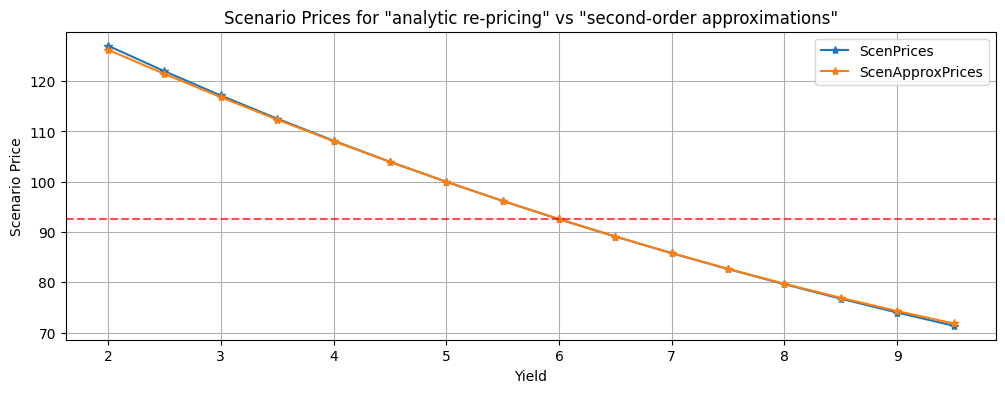

In [6]:
def calc_second_order_price_change(dirty_price, yield_diff, duration, convexity):
    return dirty_price * (- yield_diff * duration + 0.5 * yield_diff*yield_diff*convexity)
    
bond_yield_grid = [y for y in np.arange(2, 10, 0.5)]
scenario_prices = [round(test_fixed_rate_bond.cleanPrice(y/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual), 3) for y in bond_yield_grid]
second_order_approx_prices = [round(test_bond_clean_price + calc_second_order_price_change(test_bond_dirty_price, (y - test_bond_yield) / 100, test_bond_duration, test_bond_convexity), 2) 
                                   for y in bond_yield_grid]

# plot bond_scennarios_df
bond_scenarios_df = pd.DataFrame(data={'ScenYields': bond_yield_grid, 'ScenPrices': scenario_prices, 'ScenApproxPrices': second_order_approx_prices})
print(bond_scenarios_df.round(1))

# Plot Scenario Prices for "analytic re-pricing" vs "second-order approximations
plt = bond_scenarios_df.plot(x='ScenYields', y=['ScenPrices', 'ScenApproxPrices'], grid=True, style='-*', title='Scenario Prices for "analytic re-pricing" vs "second-order approximations"', figsize=(12,4))
plt.axhline(test_bond_clean_price, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Scenario Price')
plt.set_xlabel('Yield')


## d. Extreme events scenarios (5 points)

Compute and show the scenario bond price for a bond yield of 15% (extreme event scenario).

Compute and show the second-order scenario price approximation in the extreme event scenario.

How accurate is the second-order scenario price approximations (using duration and convexity sensitivities)?

Compute and show the analytic DV01, duration and convexity in the extreme event scenario.

In [7]:
extreme_event_bond_yield = 15
extreme_event_bond_clean_price = round(test_fixed_rate_bond.cleanPrice(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual), 3)
extreme_event_second_order_approx_price = round(test_bond_clean_price + calc_second_order_price_change(test_bond_dirty_price, (extreme_event_bond_yield - test_bond_yield) / 100, test_bond_duration, test_bond_convexity), 2) 
                             
print('extreme_event_scenario_price:', extreme_event_bond_clean_price)
print('extreme_event_second_order_approx_price:', extreme_event_second_order_approx_price)
print('extreme_event_approx_error:', round(extreme_event_second_order_approx_price - extreme_event_bond_clean_price, 2))                             

extreme_event_scenario_price: 49.051
extreme_event_second_order_approx_price: 55.62
extreme_event_approx_error: 6.57


The second-order scenario price approximations (quadratic Taylor approximation using duration and convexity) is only accurate locally, for relatively small yield changes. It is not accurate for large yield changes, as we can see above.

In [8]:
# Compute analytical duration and convexity
extreme_event_bond_dirty_price = round(test_fixed_rate_bond.dirtyPrice(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual), 3)
extreme_event_bond_yield_rate = ql.InterestRate(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
extreme_event_bond_duration = ql.BondFunctions.duration(test_fixed_rate_bond, extreme_event_bond_yield_rate)
extreme_event_bond_convexity = ql.BondFunctions.convexity(test_fixed_rate_bond, extreme_event_bond_yield_rate)
extreme_event_bond_dv01 = extreme_event_bond_duration * extreme_event_bond_dirty_price / 100

# show the scenario DV01, duration and convexity for a bond yield of 15% (extreme event scenario)
print('extreme_event_bond_dv01:', round(extreme_event_bond_dv01, 2))
print('extreme_event_bond_duration:', round(extreme_event_bond_duration, 2))
print('extreme_event_bond_convexity:', round(extreme_event_bond_convexity, 2))



extreme_event_bond_dv01: 3.16
extreme_event_bond_duration: 6.43
extreme_event_bond_convexity: 55.3


-----------------------------------------------------------
# Problem 3: LQD basket analysis - pricing and bucketed interest rate hedging (30 points)

## Use the solution from Homework 5 Problem 5 as a template.

## a. Load and explore the LQD basket composition and market data (5 points)

Load the `lqd_basket_composition` Excel file into a dataframe. It contains the LQD basket constituent face notionals, weights and yields-to-maturities as of 2023-05-19.

The `corp_symbology` dataframe already contains the corporate bond details for LQD constituents.

How many corporate bonds are in the LQD basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the LQD basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [9]:
# lqd_corp_symbology_df
corp_symbology_df = pd.read_excel('../data/corp_symbology.xlsx')

# Load LQD basket composition file, keep only columns needed for pricing
lqd_basket_composition_df = pd.read_excel('../data/lqd_basket_composition.xlsx')
lqd_basket_composition_df = lqd_basket_composition_df[['isin', 'yield_to_maturity', 'face_notional', 'face_notional_weight']]

# lqd_df
lqd_df = corp_symbology_df.merge(lqd_basket_composition_df, how='inner', on=['isin'])
# print(lqd_df.head())

print('Corporate bonds in LQD basket:', lqd_df.shape[0])

print('Average and median face notionals for bonds in HYG basket:')
print(lqd_df['face_notional'].describe()[['mean', '50%']])

print('Number of unique tickers in LQD basket:', len(lqd_df['ticker'].unique()))

print('Average and median face notionals by ticker:')
lqd_by_ticker_df = lqd_df[['ticker', 'face_notional']].groupby(['ticker']).sum()
print(lqd_by_ticker_df['face_notional'].describe()[['mean', '50%']])

print('Mean, median and standard deviation of yields-to-maturity (pct):')
print(lqd_df['yield_to_maturity'].describe()[['mean', '50%', 'std']])


Corporate bonds in LQD basket: 2628
Average and median face notionals for bonds in HYG basket:
mean    1.508173e+07
50%     1.255950e+07
Name: face_notional, dtype: float64
Number of unique tickers in LQD basket: 391
Average and median face notionals by ticker:
mean    1.013677e+08
50%     4.386800e+07
Name: face_notional, dtype: float64
Mean, median and standard deviation of yields-to-maturity (pct):
mean    5.383634
50%     5.330000
std     0.658203
Name: yield_to_maturity, dtype: float64


## b. Compute the NAV of the LQD basket on $100 face notional. (5 points)

Create the bond objects for all constituents of LQD. Compute the dirty price for each bond (from yield-to-maturity in the `lqd_basket_composition` dataframe).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

In [10]:
# face notionals weights
bond_face_notional_weights = lqd_df['face_notional_weight']

# bond objects and dirty prices
lqd_bond_objects = []
lqd_bond_dirty_prices = []

# ETF intrinsic  NAV and Market Cap
lqd_intrinsic_nav = 0

# loop over bonds
for i, df_row in lqd_df.iterrows():
    # bond_object
    bond_object = create_bond_from_symbology(df_row.to_dict())
    
    # bond_dirty_price                
    bond_yield = df_row['yield_to_maturity'] / 100
    bond_dirty_price = bond_object.dirtyPrice(bond_yield, bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    
    # lqd_basket_nav    
    lqd_intrinsic_nav += bond_dirty_price * bond_face_notional_weights[i] / 100
        
    # Populate lists
    lqd_bond_objects.append(bond_object)
    lqd_bond_dirty_prices.append(bond_dirty_price)


# Add dirty prices to lqd_df
lqd_df['dirty_price'] = lqd_bond_dirty_prices
print(lqd_df[['security', 'yield_to_maturity', 'face_notional', 'dirty_price']].head())

print('Aggregated NAV value (intrisic value of bond basket):')
print('lqd_intrinsic_nav (on a face of $100):', round(lqd_intrinsic_nav, 2))


            security  yield_to_maturity  face_notional  dirty_price
0  AES 2.45 01/15/31               5.82       19060000    80.309740
1  AES 5.45 06/01/28               5.70        7160000    99.013719
2     T 4.3 12/15/42               5.74       13864000    85.089383
3    T 4.35 06/15/45               5.84       12671000    83.557746
4   T 4 1/2 05/15/35               5.49       25736000    91.491955
Aggregated NAV value (intrisic value of bond basket):
lqd_intrinsic_nav (on a face of $100): 89.03


## c. Compute the intrinsic price of one LQD ETF share. (5 points)

Compute the intrinisc market capitalization of the LQD ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 328,600,000 (the number of LQD shared outstanding as of 2023-05-19) to obtain the intrinsic price of one LQD ETF share.

In [11]:

# Compute total face notonal of LQD basket
lqd_total_face_notional = lqd_df['face_notional'].sum() 
print('lqd_total_face_notional (in $BN):', round(lqd_total_face_notional/1e9, 2))

# Compute the intrinisc market capitalization of the HYG ETF by scaling the ETF NAV price to the ETF total face notional. 
lqd_intrinsic_market_cap = lqd_intrinsic_nav * lqd_total_face_notional / 100
print('lqd_intrinsic_market_cap (in $BN):', round(lqd_intrinsic_market_cap/1e9, 2))

# Divide by 195,800,000 (the number of ETF shared outstanding as of 2023-05-12) to obtain the intrinsic price of one HYG ETF share.
lqd_number_of_outstanding_etf_shares = 328600000
print('lqd_number_of_outstanding_etf_shares', lqd_number_of_outstanding_etf_shares)

lqd_intrinsic_price_per_etf_share = lqd_intrinsic_market_cap / lqd_number_of_outstanding_etf_shares
print('lqd_intrinsic_price_per_etf_share:', round(lqd_intrinsic_price_per_etf_share, 2))


lqd_total_face_notional (in $BN): 39.63
lqd_intrinsic_market_cap (in $BN): 35.29
lqd_number_of_outstanding_etf_shares 328600000
lqd_intrinsic_price_per_etf_share: 107.38


## d. Compute the scenario DV01s of the Benchmark US Treasuries (5 points)

Use the `und_bench_tsy_isin` column in the bond symbology dataframe to find the Benchmark US Treasuries used for bucketed hedging in the LQD portfolio (there should be 7 of them). 

Compute the scenario DV01 for each Benchmark US Treasury (bump the yield by -1 bp and re-price the bond).


In [12]:
und_bench_tsy_isins = lqd_df['und_bench_tsy_isin'].unique()
print(und_bench_tsy_isins)

['US91282CHC82' 'US91282CHA27' 'US912810TQ13' 'US912810TN81'
 'US91282CHB00' 'US91282CGZ86' 'US91282CGX39']


In [13]:
# govt_symbology_df
govt_symbology_df = pd.read_excel('../data/govt_symbology.xlsx')

# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')

# filter for und_bench_tsy_isins
bench_tsy_symbology_df = govt_symbology_df.set_index('isin', inplace=False).loc[und_bench_tsy_isins]
bench_tsy_symbology_df.sort_values('maturity', inplace=True)
# print(bench_tsy_symbology_df)

# bench_tsy_df
bench_tsy_df = bench_tsy_symbology_df.merge(market_prices_df, how='inner', on=['figi', 'class', 'ticker', 'isin'])
bench_tsy_df['mid_yield'] = (bench_tsy_df['bid_yield'] + bench_tsy_df['ask_yield']) / 2
print(bench_tsy_df[['figi', 'security', 'mid_clean', 'mid_yield']])

# set isin as index
bench_tsy_df.set_index('isin', inplace=True)


           figi          security  mid_clean  mid_yield
0  BBG01GCWF1J0  T 3 7/8 04/30/25    99.2734     4.2680
1  BBG01GJ2R1W1  T 3 5/8 05/15/26    99.0898     3.9515
2  BBG01GCWDXL9  T 3 1/2 04/30/28    98.9570     3.7330
3  BBG01GCWF002  T 3 1/2 04/30/30    98.7188     3.7110
4  BBG01GJ2R4D6  T 3 3/8 05/15/33    97.5078     3.6755
5  BBG01F6N6GN1  T 3 7/8 02/15/43    97.5391     4.0570
6  BBG01DVKBH56  T 3 5/8 02/15/53    94.5703     3.9365


In [14]:
# compute underlyting treasury scenario DV01s
tsy_bond_objects = []
tsy_bond_dv01s = []

# loop over bonds
for i, df_row in bench_tsy_df.iterrows():
    # tsy_bond_object
    tsy_bond_object = create_bond_from_symbology(df_row.to_dict())    
    
    # tsy bond yields
    tsy_bond_yield = df_row['mid_yield'] / 100
    tsy_bond_yield_1bp_down = tsy_bond_yield - 0.0001
    
    # calc tsy_bond_price, tsy_bond_price_1bp_down and tsy_bond_dv01
    tsy_bond_price = tsy_bond_object.cleanPrice(tsy_bond_yield, tsy_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    tsy_bond_price_1bp_down = tsy_bond_object.cleanPrice(tsy_bond_yield_1bp_down, tsy_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    tsy_bond_dv01 = (tsy_bond_price_1bp_down - tsy_bond_price) * 1e4 / 100
    
    tsy_bond_objects.append(tsy_bond_object)
    tsy_bond_dv01s.append(tsy_bond_dv01)
    

bench_tsy_df['dv01'] = tsy_bond_dv01s
print(bench_tsy_df[['security', 'mid_yield', 'dv01']])


                      security  mid_yield       dv01
isin                                                
US91282CGX39  T 3 7/8 04/30/25     4.2680   1.835406
US91282CHB00  T 3 5/8 05/15/26     3.9515   2.771605
US91282CHA27  T 3 1/2 04/30/28     3.7330   4.448076
US91282CGZ86  T 3 1/2 04/30/30     3.7110   6.026938
US91282CHC82  T 3 3/8 05/15/33     3.6755   8.175358
US912810TQ13  T 3 7/8 02/15/43     4.0570  13.291684
US912810TN81  T 3 5/8 02/15/53     3.9365  16.798948


## e. Compute the bucketed interest rate DV01s and hedging notionals in terms of benchmark treasuries. (5 points)

For each bond:
1. Compute the DV01, using either the analytic or scenario method. 
2. Identify the Benchmark US Treasury (via the `security` column) which will be used to hedge the interest rate exposure of the corporate bond.
3. Compute the hedge notional in the Benchmark US Treasury, using the ratio of corporate bond DV01 over Benchmark Treasury DV01.

Extend the LQD combined dataframe with the following columns:


| dv01 |  und_bench_tsy_security | und_bench_tsy_dv01 | und_bench_tsy_hedge_notional |
|----------|-------------|-------|-------------|

where

- dv01 = corporate bond DV01
- und_bench_tsy_security = Underlying Benchmark US Treasury `security` name
- und_bench_tsy_dv01 = Underlying Benchmark US Treasury DV01
- und_bench_tsy_hedge_notional = dv01 / und_bench_tsy_dv01


In [15]:
# compute corporate bond scenario DV01s
corp_bond_dv01s = []
bench_tsy_securities = []
und_bench_tsy_dv01s = []
und_bench_tsy_hedge_notionals = []

# loop over LQD bonds
for i, df_row in lqd_df.iterrows():
    # corp_bond_object
    corp_bond_object = lqd_bond_objects[i]
    
    # bumped corp bond yield
    corp_bond_yield = df_row['yield_to_maturity'] / 100
    corp_bond_yield_1bp_down = corp_bond_yield - 0.0001
    
    # calc corp_bond_price, corp_bond_price_1bp_down and corp_bond_dv01
    corp_bond_price = corp_bond_object.cleanPrice(corp_bond_yield, corp_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    corp_bond_price_1bp_down = corp_bond_object.cleanPrice(corp_bond_yield_1bp_down, corp_bond_object.dayCounter(), ql.Compounded, ql.Semiannual)
    corp_bond_dv01 = (corp_bond_price_1bp_down - corp_bond_price) * 1e4 / 100

    # bench_tsy_security
    bench_tsy_isin = df_row['und_bench_tsy_isin']
    bench_tsy_df_row = bench_tsy_df.loc[bench_tsy_isin]
    bench_tsy_security = bench_tsy_df_row['security']
    
    # und_bench_tsy_dv01 and und_bench_tsy_hedge_notional
    und_bench_tsy_dv01 = bench_tsy_df_row['dv01']
    und_bench_tsy_hedge_notional = corp_bond_dv01 / und_bench_tsy_dv01 * 100
    
    corp_bond_dv01s.append(corp_bond_dv01)
    bench_tsy_securities.append(bench_tsy_security)
    und_bench_tsy_dv01s.append(und_bench_tsy_dv01)
    und_bench_tsy_hedge_notionals.append(und_bench_tsy_hedge_notional)

lqd_df['dv01'] = corp_bond_dv01s
lqd_df['bench_tsy_security'] = bench_tsy_securities
lqd_df['und_bench_tsy_dv01'] = und_bench_tsy_dv01s
lqd_df['und_bench_tsy_hedge_notional'] = und_bench_tsy_hedge_notionals

print(lqd_df[['security', 'bench_tsy_security', 'dv01', 'und_bench_tsy_dv01', 'und_bench_tsy_hedge_notional']].head())

            security bench_tsy_security       dv01  und_bench_tsy_dv01   
0  AES 2.45 01/15/31   T 3 3/8 05/15/33   5.344791            8.175358  \
1  AES 5.45 06/01/28   T 3 1/2 04/30/28   4.287585            4.448076   
2     T 4.3 12/15/42   T 3 7/8 02/15/43  10.322993           13.291684   
3    T 4.35 06/15/45   T 3 7/8 02/15/43  10.718598           13.291684   
4   T 4 1/2 05/15/35   T 3 3/8 05/15/33   8.229625            8.175358   

   und_bench_tsy_hedge_notional  
0                     65.376841  
1                     96.391912  
2                     77.665046  
3                     80.641385  
4                    100.663790  


## f. Compute the bucketed interest rate DV01 and hedging notionals for the LQD ETF basket. (5 points)

Compute interest rate DV01 exposure of the LQD ETF NAV (on a face of $100) to the 7 benchmark treasury buckets.

Compute interest rate hedging notionals of the LQD ETF NAV (on a face of $100) to the 7 benchmark treasury buckets.

What treasury notionals (in the 7 Benchmark US Treasuries) are needed for a bucketed interest rate hedge of 100,000 shares of LQD? Display the results.


                    face_notional_weight  etf_nav_tsy_dv01   
bench_tsy_security                                           
T 3 1/2 04/30/28               27.620615          1.228586  \
T 3 1/2 04/30/30                0.632021          0.038091   
T 3 3/8 05/15/33               29.675095          2.426045   
T 3 5/8 02/15/53               22.731134          3.818591   
T 3 5/8 05/15/26                4.824439          0.133714   
T 3 7/8 02/15/43               14.454526          1.921250   
T 3 7/8 04/30/25                0.062170          0.001141   
Total                         100.000000          9.567419   

                    etf_nav_tsy_hedge_notional  
bench_tsy_security                              
T 3 1/2 04/30/28                     26.194410  
T 3 1/2 04/30/30                      0.589507  
T 3 3/8 05/15/33                     24.597443  
T 3 5/8 02/15/53                     16.075538  
T 3 5/8 05/15/26                      5.238081  
T 3 7/8 02/15/43                    

<Axes: title={'center': 'Bucketed interest rate hedging for LQD (using benchmark treasuries)'}, xlabel='bench_tsy_security'>

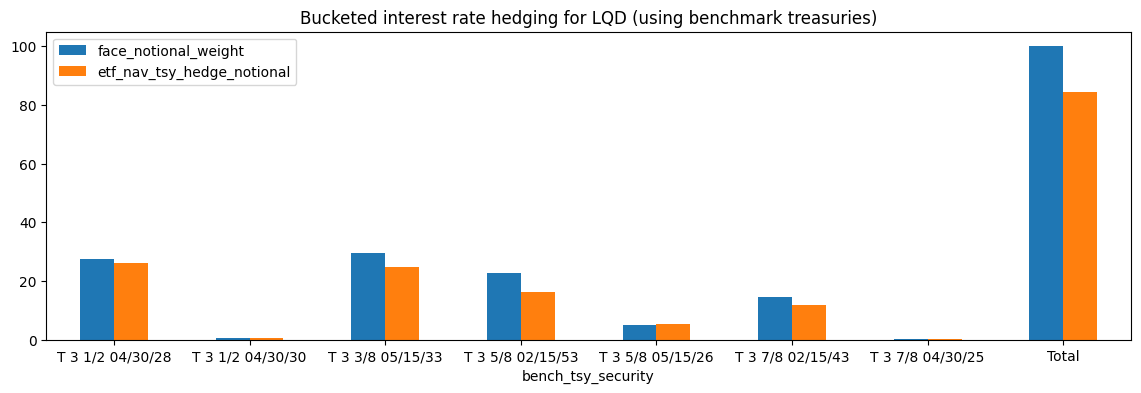

In [16]:
# DV01 and hedge ratios for LQD ETF NAV (synthetic bond on a face of $100)
lqd_df['etf_nav_tsy_dv01'] = lqd_df['face_notional_weight'] * lqd_df['und_bench_tsy_dv01'] / 100
lqd_df['etf_nav_tsy_hedge_notional'] = lqd_df['face_notional_weight'] * lqd_df['und_bench_tsy_hedge_notional'] / 100

lqd_bucketed_dv01_hedges = lqd_df[['bench_tsy_security', 'face_notional_weight', 'etf_nav_tsy_dv01', 'etf_nav_tsy_hedge_notional']].groupby(['bench_tsy_security']).sum()
lqd_bucketed_dv01_hedges.loc['Total']= lqd_bucketed_dv01_hedges.sum()
print(lqd_bucketed_dv01_hedges)

# plot bar chart
lqd_bucketed_dv01_hedges.plot.bar(y=['face_notional_weight', 'etf_nav_tsy_hedge_notional'], rot=0, title='Bucketed interest rate hedging for LQD (using benchmark treasuries)', figsize=(14,4))

                    lqd_100k_tsy_dv01_usd  lqd_100k_tsy_hedge_notional_usd
bench_tsy_security                                                        
T 3 1/2 04/30/28                  1481.88                       3159494.23
T 3 1/2 04/30/30                    45.94                         71104.63
T 3 3/8 05/15/33                  2926.23                       2966872.67
T 3 5/8 02/15/53                  4605.87                       1938985.02
T 3 5/8 05/15/26                   161.28                        631802.19
T 3 7/8 02/15/43                  2317.36                       1407366.25
T 3 7/8 04/30/25                     1.38                         24502.63
Total                            11539.95                      10200127.61


<Axes: title={'center': 'Bucketed interest rate DV01s (USD) for 100K shares of LQD'}, xlabel='bench_tsy_security'>

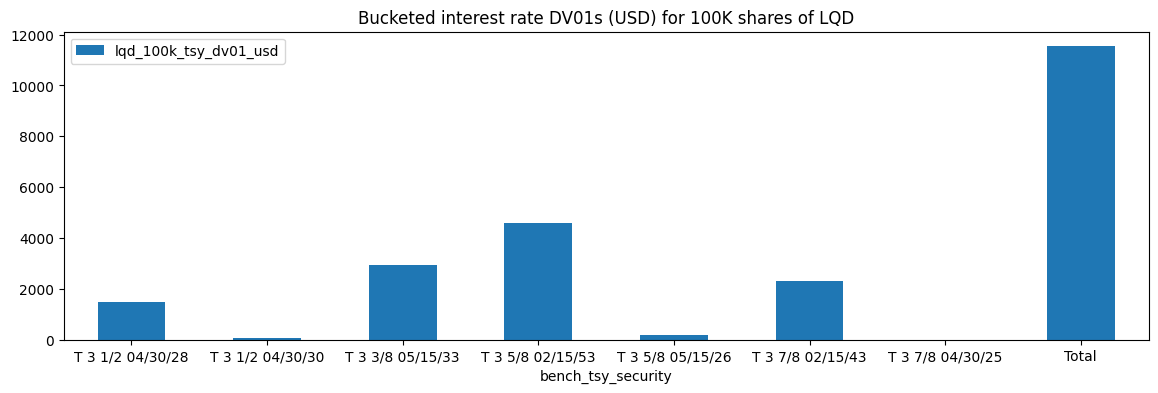

In [17]:
# bucketed interest rate hedge of 100,000 shares of LQD
number_of_lqd_shares = 100000
multiplier_for_100k_shares = lqd_total_face_notional / lqd_number_of_outstanding_etf_shares * number_of_lqd_shares / 100
lqd_bucketed_dv01_hedges['lqd_100k_tsy_dv01_usd'] = round(lqd_bucketed_dv01_hedges['etf_nav_tsy_dv01'] * multiplier_for_100k_shares / 100, 2)
lqd_bucketed_dv01_hedges['lqd_100k_tsy_hedge_notional_usd'] = round(lqd_bucketed_dv01_hedges['etf_nav_tsy_hedge_notional'] * multiplier_for_100k_shares, 2)

print(lqd_bucketed_dv01_hedges[['lqd_100k_tsy_dv01_usd', 'lqd_100k_tsy_hedge_notional_usd']])

# plot bar chart
lqd_bucketed_dv01_hedges.plot.bar(y=['lqd_100k_tsy_dv01_usd'], rot=0, title='Bucketed interest rate DV01s (USD) for 100K shares of LQD', figsize=(14,4))

--------------------------------------------------------------------------------------
# Problem 4: Portfolio risk analysis in the Nelson-Siegel model (30 points)

## Use the solution code from Homework 4 Problem 3 as a template!

## a. Prepare the symbology + market data (5 points)
Load and merge the symbology + market data dataframes for all AT&T fixed rate corporate bonds (ticker = 'T') as of 2023-05-19. 

Calibrate the "on-the-run" US Treasury curve as of 2023-05-19 (using code from previous homeworks).

In [18]:
# corp_symbology_df
corp_symbology_df = pd.read_excel('../data/corp_symbology.xlsx')
corp_symbology_df = corp_symbology_df[corp_symbology_df.cpn_type == 'FIXED']
att_symbology_df = corp_symbology_df[corp_symbology_df.ticker == 'T']

# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')

# att_df
att_df = att_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
att_df['market_price'] = att_df['mid_clean']
att_df['market_yield'] = (att_df['bid_yield'] + att_df['ask_yield']) / 2
att_df.sort_values('maturity',inplace=True)
print(att_df.head())


   ticker class          figi          isin     trace und_bench_tsy_isin   
58      T  Corp  BBG00ZR6MM60  US00206RMJ85  T5153066       US91282CGX39  \
29      T  Corp  BBG00P7S8PJ1  US00206RHT23  T4833806       US91282CHB00   
62      T  Corp  BBG01FC3Q239  US00206RMP46  T5543175       US91282CGX39   
23      T  Corp  BBG00MDNZ0F1  US00206RGH93  T4762513       US91282CHB00   
59      T  Corp  BBG00ZR6MMN1  US00206RML32  T5153067       US91282CHB00   

            security      name    type  coupon  ... status       date   
58    T 0.9 03/25/24  AT&T INC  GLOBAL   0.900  ...   ACTV 2023-05-19  \
29  T 3 7/8 01/15/26  AT&T INC  GLOBAL   3.875  ...   ACTV 2023-05-19   
62  T 5.539 02/20/26  AT&T INC  GLOBAL   5.539  ...   ACTV 2023-05-19   
23  T 7 1/8 03/15/26  AT&T INC  GLOBAL   7.125  ...   ACTV 2023-05-19   
59    T 1.7 03/25/26  AT&T INC  GLOBAL   1.700  ...   ACTV 2023-05-19   

        bid      ask mid_clean mid_dirty bid_yield ask_yield market_price   
58   96.307   96.530    96.

In [19]:

# Calibrate the "on-the-run" US Treasury curve as of 2023-05-19.

# govt_symbology_df
govt_symbology_df = pd.read_excel('../data/govt_symbology.xlsx')

# govt_otr_df
govt_otr_df = pd.read_excel('../data/govt_on_the_run.xlsx')
govt_otr_df.set_index('ticker',inplace=True)

# filter for on_the_run_tsy_tickers
on_the_run_tsy_tickers = ['GT2 Govt', 'GT3 Govt', 'GT5 Govt', 'GT7 Govt', 'GT10 Govt', 'GT20 Govt', 'GT30 Govt']
on_the_run_tsy_figis = govt_otr_df.loc[on_the_run_tsy_tickers]['figi']

# govt_otr_symbology_df
govt_otr_symbology_df = govt_symbology_df.set_index('figi',inplace=False).loc[on_the_run_tsy_figis]
# print(govt_otr_symbology_df)

# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')
market_prices_df.set_index('date',inplace=True)

# treasury_otr_df
treasury_otr_df = govt_otr_symbology_df.merge(market_prices_df.loc['2023-05-19'], how='inner', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])

# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)
print(tsy_yield_curve_handle)



           figi          security      bid      ask  bid_yield  bid_yield
0  BBG01GCWF1J0  T 3 7/8 04/30/25  99.2695  99.2773      4.270      4.270
1  BBG01GJ2R1W1  T 3 5/8 05/15/26  99.0859  99.0938      3.953      3.953
2  BBG01GCWDXL9  T 3 1/2 04/30/28  98.9531  98.9609      3.734      3.734
3  BBG01GCWF002  T 3 1/2 04/30/30  98.6875  98.7500      3.716      3.716
4  BBG01GJ2R4D6  T 3 3/8 05/15/33  97.4844  97.5313      3.678      3.678
5  BBG01GM76FT2  T 3 7/8 05/15/43  97.4375  97.5156      4.064      4.064
6  BBG01GJ2QXX1  T 3 5/8 05/15/53  94.6250  94.7031      3.932      3.932
<QuantLib.QuantLib.YieldTermStructureHandle; proxy of <Swig Object of type 'Handle< YieldTermStructure > *' at 0x000001FF8B185440> >


## b. Calibrate the Nelson-Siegel smooth AT&T credit curve in hazard rate space (5 points)

Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.


In [20]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# initial_nelson_siegel_params
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
print('initial_nelson_siegel_params:', initial_nelson_siegel_params)

fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(att_df, tsy_yield_curve_handle)
att_df['duration'] = bond_durations
att_df['calib_weight'] = calib_weights

init_bond_model_prices, init_bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, 
                                                                                                 calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
att_df['init_model_price'] = init_bond_model_prices
att_df['init_model_yield'] = init_bond_model_yields
print(att_df[['security', 'market_price', 'init_model_price', 'calib_weight']].head())

# initial_sse
initial_sse = nelson_siegel_sse(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', initial_sse)


initial_nelson_siegel_params: [0.03, -0.01, 0.02, 5.0]
            security  market_price  init_model_price  calib_weight
58    T 0.9 03/25/24        96.419         95.917085      0.057418
29  T 3 7/8 01/15/26        97.720         95.677225      0.046975
62  T 5.539 02/20/26       100.117         99.724077      0.046315
23  T 7 1/8 03/15/26       104.852        103.713743      0.045822
59    T 1.7 03/25/26        91.547         90.075670      0.042436
initial_sse = 1.5923171069921336


In [21]:
# calibrate_nelson_siegel_model
calib_results = calibrate_nelson_siegel_model(initial_nelson_siegel_params, calc_date, att_df, tsy_yield_curve_handle, bond_recovery_rate)
print(calib_results)
    
# calib_nelson_siegel_params
calib_nelson_siegel_params = calib_results.x
print('calib_nelson_siegel_params:', calib_nelson_siegel_params)

# calib_nelson_siegel_curve
calib_nelson_siegel_curve = create_nelson_siegel_curve(calc_date, calib_nelson_siegel_params)

# calib_sse
calib_sse = nelson_siegel_sse(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', round(initial_sse, 3), 'calib_sse =', round(calib_sse, 3))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.8369999293455554
        x: [ 4.534e-02 -4.044e-02  1.477e-04  5.018e+00]
      nit: 16
      jac: [ 7.741e+00  2.956e+00  1.585e+00  7.383e-03]
     nfev: 335
     njev: 67
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
calib_nelson_siegel_params: [ 4.53383216e-02 -4.04446755e-02  1.47665779e-04  5.01793203e+00]
initial_sse = 1.592 calib_sse = 0.837


## c. Compute Nelson-Siegel model prices, yield and edges for individual bonds. (5 points)

Price all AT&T bonds on the calibrated credit curve and compute the model prices and yields.

Plot the model vs market yields (Y-axis) by time to maturity (X-axis).

Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

In [22]:
# bond_model_prices
bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
att_df['model_price'] = bond_model_prices
att_df['model_yield'] = bond_model_yields
att_df['edge_price'] = round(att_df['model_price'] - att_df['market_price'], 3)
att_df['edge_yield'] = round(att_df['model_yield'] - att_df['market_yield'], 3)

print(att_df[['security', 'market_price','init_model_price', 'model_price', 'edge_price']].head())
print(att_df[['security', 'market_yield','init_model_yield', 'model_yield', 'edge_yield']].tail())

            security  market_price  init_model_price  model_price  edge_price
58    T 0.9 03/25/24        96.419         95.917085    96.592408       0.173
29  T 3 7/8 01/15/26        97.720         95.677225    97.423676      -0.296
62  T 5.539 02/20/26       100.117         99.724077   101.601718       1.485
23  T 7 1/8 03/15/26       104.852        103.713743   105.706503       0.855
59    T 1.7 03/25/26        91.547         90.075670    91.793855       0.247
            security  market_yield  init_model_yield  model_yield  edge_yield
20    T 5.3 08/15/58        6.0370          5.754758     5.875184      -0.162
52   T 3.65 09/15/59        5.8135          5.428344     5.560802      -0.253
55   T 3.65 09/15/59        5.8285          5.428344     5.560802      -0.268
44   T 3.85 06/01/60        5.8185          5.468278     5.601339      -0.217
47  T 3 1/2 02/01/61        5.6120          5.378699     5.514085      -0.098


Text(0.5, 0, 'Bond Maturity')

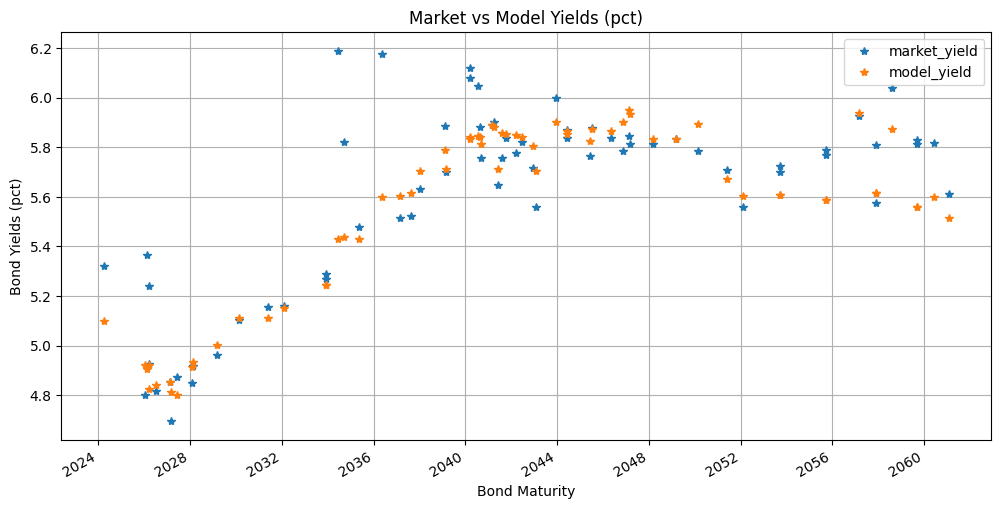

In [23]:
plt = att_df.plot(x='maturity', y = ['market_yield', 'model_yield'], figsize = (12, 6), title = "Market vs Model Yields (pct)", grid=True, style='*')
plt.set_ylabel('Bond Yields (pct)')
plt.set_xlabel('Bond Maturity')

Text(0.5, 0, 'Bond Maturity')

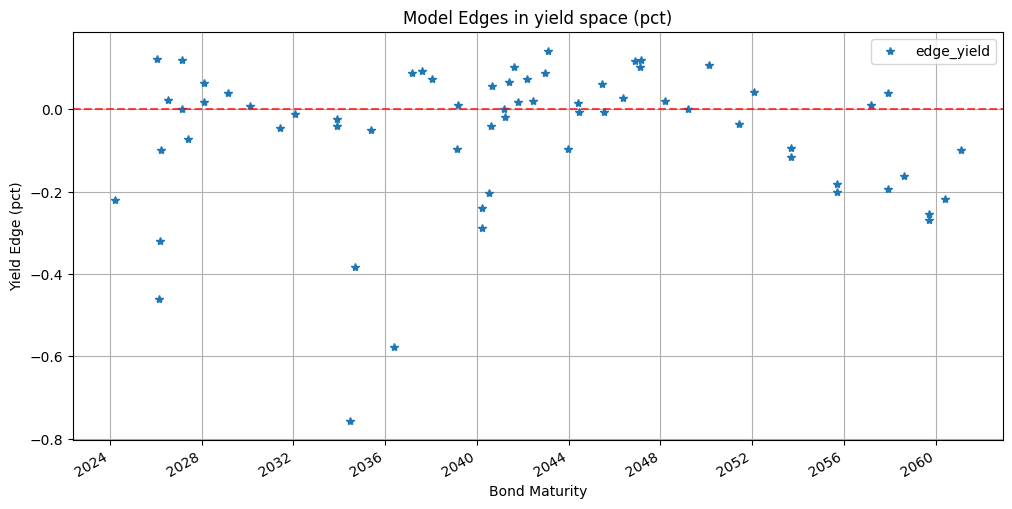

In [24]:
plt = att_df.plot(x='maturity', y = ['edge_yield'], figsize = (12, 6), title = "Model Edges in yield space (pct)", grid=True, style='*')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Yield Edge (pct)')
plt.set_xlabel('Bond Maturity')


## d. Load the AT&T bond portfolio and compute the aggregated model edge in the portfolio (5 points)

Load the bond portfolio positions file `bond_portoflio_att`, which contains long and short positions in AT&T bonds. 

Comput the total/aggregated "model edge" in the portfolio.

In [25]:
# bond_port_df
bond_port_df = pd.read_excel('../data/att_bond_portfolio.xlsx')

# print(att_df[['figi', 'edge_price', 'edge_yield']].head())
bond_port_df = bond_port_df.merge(att_df[['figi', 'edge_price', 'edge_yield']], how='inner', on=['figi'])
bond_port_df['edge_usd'] = bond_port_df['edge_price'] * bond_port_df['position_usd'] / 100
# print(bond_port_df.head())

# aggregate edge_usd by Long/Short positions
bond_port_df['pos_sign'] = 'LONG'
bond_port_df.loc[bond_port_df['position_usd'] < 0, 'pos_sign'] = 'SHORT'
agg_bond_port_df = bond_port_df[['pos_sign', 'position_usd', 'edge_usd']].groupby(['pos_sign']).sum()

# add net and gross
agg_bond_port_df_net = agg_bond_port_df.sum()
agg_bond_port_df_gross = agg_bond_port_df.abs().sum()
agg_bond_port_df.loc['NET'] = agg_bond_port_df_net
agg_bond_port_df.loc['GROSS']= agg_bond_port_df_gross

# display portfolio edge summary
print(agg_bond_port_df)



          position_usd  edge_usd
pos_sign                        
LONG        30000000.0  180840.0
SHORT      -30000000.0  -63640.0
NET                0.0  117200.0
GROSS       60000000.0  244480.0


## e. Compute sensitivities to the Nelson-Siegel "credit curve shape" model parameters (5 points)

Create the following Nelson-Siegel scenario credit curves:
1. Parallel shift (credit level change) scenario in hazard rate curve: bump $\theta_1$ model parameter by 1bp
1. Steepener (credit slope change) scenario in hazard rate curve: bump $\theta_2$ model parameter by 1bp
1. Curvature (credit convexity change) scenario in hazard rate curve: bump $\theta_3$ model parameter by 1bp

For each bond, compute the model prices and corresponding factor sensitivites in the three scenarios:
* Credit_Level_01 = $\frac{\partial B}{\partial \theta_1}$, 
* Credit_Slope_01  = $\frac{\partial B}{\partial \theta_2}$ and 
* Credit_Convexity_01  = $\frac{\partial B}{\partial \theta_3}$.

Display the sensitivities for the first 5 bonds in the AT&T dataframe.

In [26]:
calib_nelson_siegel_params_theta1_1bp_up = calib_nelson_siegel_params.copy()
calib_nelson_siegel_params_theta1_1bp_up[0] = calib_nelson_siegel_params[0] + 0.0001

calib_nelson_siegel_params_theta2_1bp_up = calib_nelson_siegel_params.copy()
calib_nelson_siegel_params_theta2_1bp_up[1] = calib_nelson_siegel_params[1] + 0.0001

calib_nelson_siegel_params_theta3_1bp_up = calib_nelson_siegel_params.copy()
calib_nelson_siegel_params_theta3_1bp_up[2] = calib_nelson_siegel_params[2] + 0.0001

# scenario bond_model_prices and yields
bond_model_prices_theta1_1bp_up, bond_model_yields_theta1_1bp_up = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params_theta1_1bp_up, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
bond_model_prices_theta2_1bp_up, bond_model_yields_theta2_1bp_up = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params_theta2_1bp_up, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
bond_model_prices_theta3_1bp_up, bond_model_yields_theta3_1bp_up = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params_theta3_1bp_up, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)

att_df['theta1_scenario_price'] = bond_model_prices_theta1_1bp_up
att_df['theta2_scenario_price'] = bond_model_prices_theta2_1bp_up
att_df['theta3_scenario_price'] = bond_model_prices_theta3_1bp_up

att_df['credit_level_01'] = att_df['theta1_scenario_price'] - att_df['model_price']
att_df['credit_slope_01'] = att_df['theta2_scenario_price'] - att_df['model_price']
att_df['credit_convexity_01'] = att_df['theta3_scenario_price'] - att_df['model_price']

# Display the sensitivities for the first 5 bonds in the AT&T dataframe.
print(att_df[['security', 'credit_level_01', 'credit_slope_01','credit_convexity_01']].head(5))


            security  credit_level_01  credit_slope_01  credit_convexity_01
58    T 0.9 03/25/24        -0.004855        -0.004402            -0.000424
29  T 3 7/8 01/15/26        -0.014805        -0.011468            -0.002778
62  T 5.539 02/20/26        -0.016001        -0.012339            -0.003040
23  T 7 1/8 03/15/26        -0.017019        -0.013100            -0.003248
59    T 1.7 03/25/26        -0.014865        -0.011308            -0.002933


Text(0.5, 0, 'Bond Maturity')

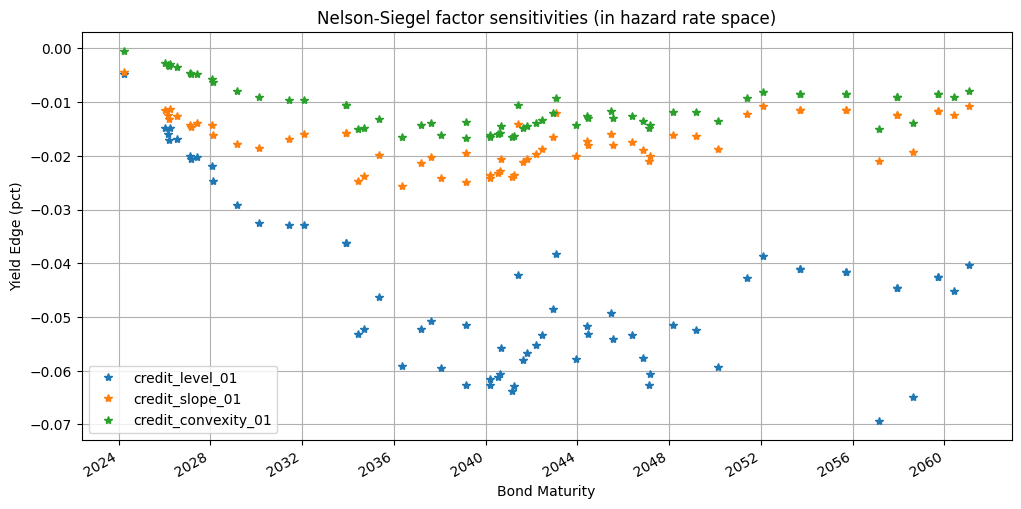

In [27]:
# Model factor sensitivities: results visualization (optional plot)
plt = att_df.plot(x='maturity', y = ['credit_level_01', 'credit_slope_01', 'credit_convexity_01'],
                   figsize = (12, 6), title = "Nelson-Siegel factor sensitivities (in hazard rate space)", grid=True, style='*')
plt.set_ylabel('Yield Edge (pct)')
plt.set_xlabel('Bond Maturity')


## f. Compute portfolio factor sensitivities (5 points)

Compute the model parameter sensitivities (factor exposures) of the `bond_portoflio_att` portfolio:
* Portfolio Credit_Level_01 = change in portfolio value for a 1bp change in $\theta_1$ model parameter.
* Portfolio Credit_Slope_01 = change in portfolio value for a 1bp change in $\theta_2$ model parameter.
* Portfolio Credit_Convexity_01 = change in portfolio value for a 1bp change in $\theta_3$ model parameter.

In [28]:
# bond_port_df
bond_port_df = pd.read_excel('../data/att_bond_portfolio.xlsx')

# add factor sensitivities to bond_port_df
bond_port_df = bond_port_df.merge(att_df[['figi', 'credit_level_01', 'credit_slope_01','credit_convexity_01']], how='left', on=['figi'])

bond_port_df['portfolio_credit_level_01'] = bond_port_df['credit_level_01'] * bond_port_df['position_usd'] / 100
bond_port_df['portfolio_credit_slope_01'] = bond_port_df['credit_slope_01'] * bond_port_df['position_usd'] / 100
bond_port_df['portfolio_credit_convexity_01'] = bond_port_df['credit_convexity_01'] * bond_port_df['position_usd'] / 100
print(bond_port_df[['security', 'position_usd', 'portfolio_credit_level_01', 'portfolio_credit_slope_01','portfolio_credit_convexity_01']].round(0).head())


           security  position_usd  portfolio_credit_level_01   
0   T 2.95 07/15/26      -1000000                      168.0  \
1    T 3.8 02/15/27      -1000000                      201.0   
2  T 4 1/4 03/01/27      -1000000                      206.0   
3    T 2.3 06/01/27      -1000000                      203.0   
4   T 1.65 02/01/28      -1000000                      220.0   

   portfolio_credit_slope_01  portfolio_credit_convexity_01  
0                      125.0                           35.0  
1                      142.0                           46.0  
2                      146.0                           47.0  
3                      140.0                           48.0  
4                      142.0                           56.0  


In [29]:
# aggregate factor senstivities by Long/Short positions
bond_port_df['pos_sign'] = 'LONG'
bond_port_df.loc[bond_port_df['position_usd'] < 0, 'pos_sign'] = 'SHORT'

# agg_bond_port_df
agg_bond_port_df = bond_port_df[['pos_sign', 'portfolio_credit_level_01', 'portfolio_credit_slope_01','portfolio_credit_convexity_01']].groupby('pos_sign').sum()

# add net and gross
agg_bond_port_df_net = agg_bond_port_df.sum()
agg_bond_port_df_gross = agg_bond_port_df.abs().sum()
agg_bond_port_df.loc['NET'] = agg_bond_port_df_net
agg_bond_port_df.loc['GROSS']= agg_bond_port_df_gross

print('Credit factor sensitivities aggregated on portfolio level:')
print(agg_bond_port_df.round(0).T)



Credit factor sensitivities aggregated on portfolio level:
pos_sign                          LONG    SHORT     NET    GROSS
portfolio_credit_level_01     -15580.0  12857.0 -2723.0  28438.0
portfolio_credit_slope_01      -5509.0   4973.0  -536.0  10482.0
portfolio_credit_convexity_01  -3837.0   3120.0  -718.0   6957.0


------------------------------------------------------------------
# Problem 5: Derivation of prices and factor sensitivities (25 points)

Starting from the fair value formulas for risky fixed rate bonds, derive the formulas for factor sensitivities.

Assume flat model parameters, T+0 settlement and zero accrued. Use the 'sympy' library (for symbolic mathematics) for help with the derivation of the formulas, as described in the the solution to Homework 3, Problem 2.

For results visualization via 3D surface plots, you can use the matplotlib plot_surface() function or similar.

### Flat Yield Model Parameters:
* maturity T (in years),
* semi-annual coupon c,
* flat bond yield y

According to formula (4) in Session 1, the bond present value is given by:

\begin{align}
RiskyBondPV=B(0,T,c,y)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
= 1+\left(\frac{c}{2 \cdot \left( e^{\frac{y}{2}}-1 \right) } -1 \right) \cdot \left(1-e^{-T\cdot y}\right)
\end{align}


The code below implements the present value function for a fixed rate bond.

It uses the 'sympy' library (symbolic mathematics) to translate a mathematical formula into a function, as described in the solution to Homework 3, Problem 2.

For plotting, we fix the bond coupon c at 5% and use the following discretization grids:
* in yield space: [y from 0% to 10% in steps of 0.5%] and 
* in time-to-maturity space: [T from 1Y to 20Y in steps of 1Y].


In [30]:
# import libraries
import sympy as sp

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# define symbolic variables
T = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c/2  / (sp.exp(y/2) - 1) - 1 )* (1 - sp.exp(-T*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function from equation
bond_pv_func = sp.lambdify([c,T,y], bond_pv_eq)

# sample_bond_pv (for c = 5%, T = 10 and y = 7%)
sample_bond_pv = round(bond_pv_func(0.05, 10, 0.07) * 100, 2)
print('Sample bond_pv (for coupon = 5%, T = 10 and y = 7%):', sample_bond_pv)

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1


(1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1

Sample bond_pv (for coupon = 5%, T = 10 and y = 7%): 84.99


Text(0.5, 0, 'Bond PV')

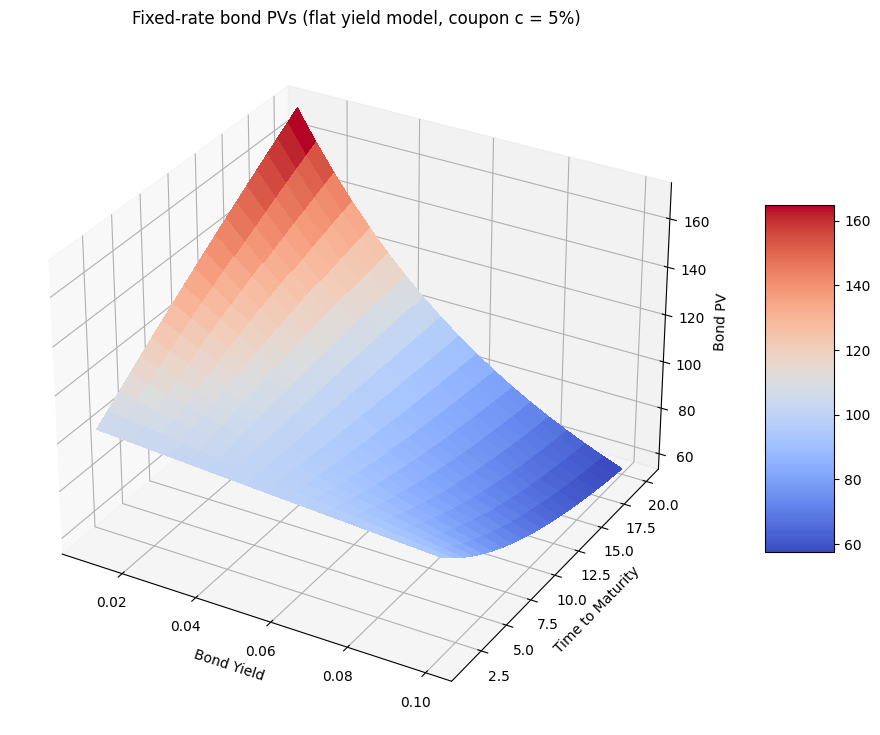

In [31]:
import numpy as np

coupon = 0.05

y_grid = np.arange(0.01, 0.105, 0.005)
T_grid = np.arange(1, 21, 1)

X, Y = np.meshgrid(y_grid, T_grid)
Z = X.copy()

# Plot the bond price surface by y and T.
for i in range(len(T_grid)):
    for j in range(len(y_grid)):
        Z[i,j] = bond_pv_func(coupon, Y[i,j], X[i,j]) * 100

# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Fixed-rate bond PVs (flat yield model, coupon c = 5%)')

ax.set_xlabel('Bond Yield')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Bond PV')

## a. Derive and implement the analytic formula for bond duration. (5 points)

Use the sympy "diff()" function to compute firt order derivatives, as explained in the solution to Homework 3, Problem 2c.

Plot the bond duration surface by y and T.

In [32]:
# Use first order derivative of pv
bond_duration_eq =  - bond_pv_eq.diff(y) / bond_pv_eq
print('bond_duration_eq:', bond_duration_eq)
display(bond_duration_eq)

# sample_bond_duration (for c = 5%, T = 10 and y = 7%)
bond_duration_func = sp.lambdify([c,T,y], bond_duration_eq)
sample_bond_duration = round(bond_duration_func(0.05, 10, 0.07), 2)
print('Sample bond_duration (for c = 5%, T = 10 and y = 7%):', sample_bond_duration)


bond_duration_eq: (-T*(c/(2*(exp(y/2) - 1)) - 1)*exp(-T*y) + c*(1 - exp(-T*y))*exp(y/2)/(4*(exp(y/2) - 1)**2))/((1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1)


(-T*(c/(2*(exp(y/2) - 1)) - 1)*exp(-T*y) + c*(1 - exp(-T*y))*exp(y/2)/(4*(exp(y/2) - 1)**2))/((1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1)

Sample bond_duration (for c = 5%, T = 10 and y = 7%): 7.79


Text(0.5, 0, 'Bond duration')

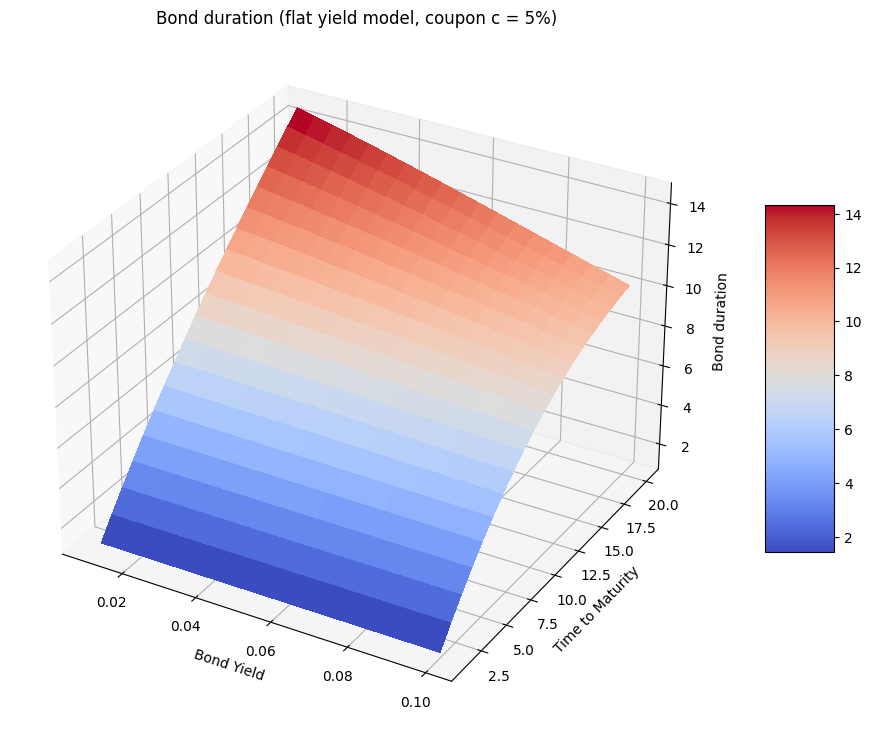

In [33]:
# Plot the bond duration surface by y and T.
for i in range(len(T_grid)):
    for j in range(len(y_grid)):
        Z[i,j] = bond_duration_func(coupon, Y[i,j], X[i,j])

# print(Z)
 
# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Bond duration (flat yield model, coupon c = 5%)')

ax.set_xlabel('Bond Yield')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Bond duration')

## b. Derive and implement the analytic formula for bond convexity.  (5 points)

Plot the bond convexity surface by y and T.

In [34]:
# Use second order derivative of pv
bond_convexity_eq =  bond_pv_eq.diff(y).diff(y) / bond_pv_eq
print('bond_convexity_eq:', bond_convexity_eq)
display(bond_convexity_eq)

# sample_bond_convexity (for c = 5%, T = 10 and y = 7%)
bond_convexity_func = sp.lambdify([c,T,y], bond_convexity_eq)
sample_bond_convexity = round(bond_convexity_func(0.05, 10, 0.07), 2)
print('Sample bond_convexity (for c = 5%, T = 10 and y = 7%):', sample_bond_convexity)


bond_convexity_eq: (-T**2*(c/(2*(exp(y/2) - 1)) - 1)*exp(-T*y) - T*c*exp(y/2)*exp(-T*y)/(2*(exp(y/2) - 1)**2) - c*(1 - exp(-T*y))*exp(y/2)/(8*(exp(y/2) - 1)**2) + c*(1 - exp(-T*y))*exp(y)/(4*(exp(y/2) - 1)**3))/((1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1)


(-T**2*(c/(2*(exp(y/2) - 1)) - 1)*exp(-T*y) - T*c*exp(y/2)*exp(-T*y)/(2*(exp(y/2) - 1)**2) - c*(1 - exp(-T*y))*exp(y/2)/(8*(exp(y/2) - 1)**2) + c*(1 - exp(-T*y))*exp(y)/(4*(exp(y/2) - 1)**3))/((1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1)

Sample bond_convexity (for c = 5%, T = 10 and y = 7%): 70.88


Text(0.5, 0, 'Bond convexity')

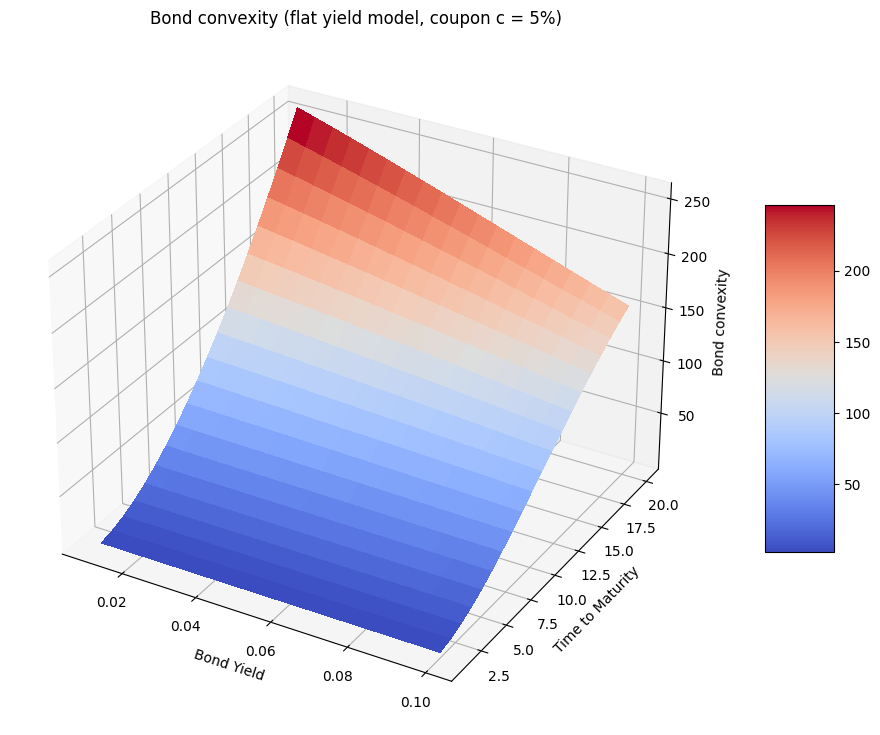

In [35]:
# Plot the bond convexity surface by y and T.
for i in range(len(T_grid)):
    for j in range(len(y_grid)):
        Z[i,j] = bond_convexity_func(coupon, Y[i,j], X[i,j])

# print(Z)
 
# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Bond convexity (flat yield model, coupon c = 5%)')

ax.set_xlabel('Bond Yield')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Bond convexity')

## Part 2: Flat Hazard Rate Model
## Parameters:
* maturity T (in years),
* semi-annual coupon c,
* flat interest rate r
* flat hazard rate h
* expected recovery rate R

According to formula (42) in Session 3, the risky bond present value is given by:

\begin{align}
RiskyBondPV=B(0,T,c,r,h,R)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\left(r+h\right)/2}+R \cdot \int_{t}^{T} h \cdot e^{- \left( t - s \right) \cdot \left(r+h\right)} \cdot ds
\end{align}


\begin{align}
= 1+\left[ \frac{c}{2 \cdot \left( e^{\frac{r+h}{2}}-1 \right) } -1 +\frac{R\cdot h}{r+h}\right] \cdot \left(1-e^{-T\cdot \left( r+h \right)}\right)
\end{align}


For results visualization, fix the bond coupon c at 5%, maturity T at 10 years and interest rates r at 4%. 

Use discretization grids [h from 1% to 10% in steps of 0.5%] and [R from 5% to 100% insteps of 5%] for 3D plotting.

## c. Fixed rate bond valuation in hazard rate model (5 points)

Implement the present value formula for the fixed rate bond.

Plot the PV surface by h and R.



In [36]:
# define symbolic variables
r = sp.symbols('r')
h = sp.symbols('h')
R = sp.symbols('R')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c / 2 / (sp.exp((r+h)/2) - 1) - 1 +R*h/(r+h))* (1 - sp.exp(-T*(r+h)))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function from equation
bond_pv_func = sp.lambdify([c,T,r,h,R], bond_pv_eq)

# sample_bond_pv (for c = 5%, T = 10, r = 4%, h = 6% and R = 40%)
sample_bond_pv = round(bond_pv_func(0.05, 10, 0.04, 0.06, 0.40) * 100, 2)
print('Sample bond_pv (for coupon = 5%, T = 10, r = 4%, h = 6%, R = 40%):', sample_bond_pv)

Analytic formula for bond_pv: (1 - exp(-T*(h + r)))*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1) + 1


(1 - exp(-T*(h + r)))*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1) + 1

Sample bond_pv (for coupon = 5%, T = 10, r = 4%, h = 6%, R = 40%): 82.78


Text(0.5, 0, 'Bond PV')

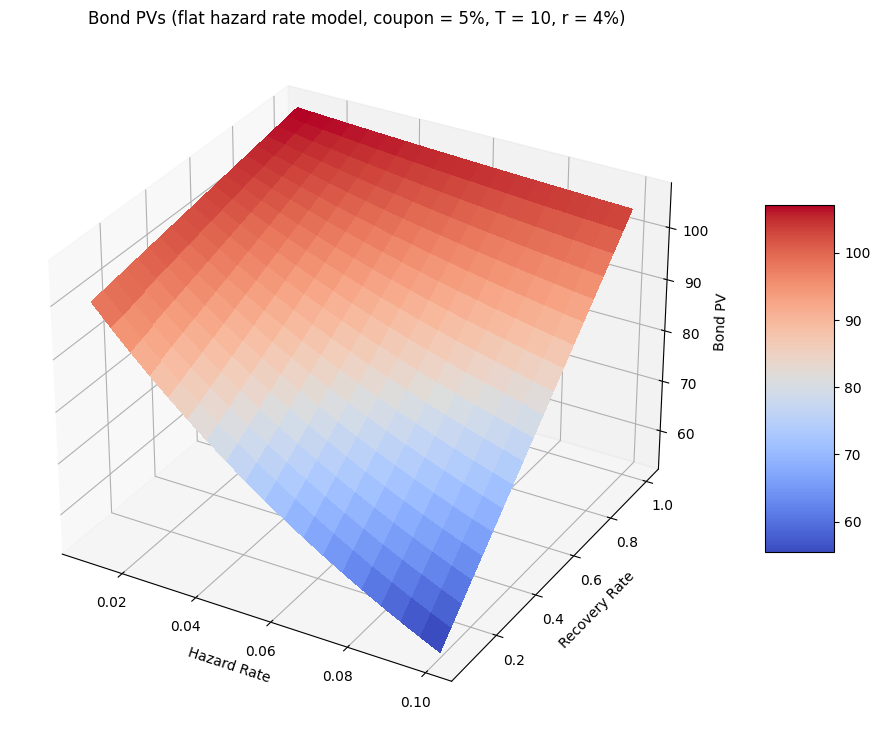

In [37]:
time_to_maturity = 10
coupon = 0.05
interest_rate = 0.04

h_grid = np.arange(0.01, 0.105, 0.005)
R_grid = np.arange(0.05, 1.05, 0.05)

X, Y = np.meshgrid(h_grid, R_grid)
Z = X.copy()

# Plot the bond price surface by h and R.
for i in range(len(R_grid)):
    for j in range(len(h_grid)):
        Z[i,j] = bond_pv_func(coupon, time_to_maturity, interest_rate, X[i,j], Y[i,j]) * 100

# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Bond PVs (flat hazard rate model, coupon = 5%, T = 10, r = 4%)')

ax.set_xlabel('Hazard Rate')
ax.set_ylabel('Recovery Rate')
ax.set_zlabel('Bond PV')

## d. Derive and implement the analytic formula for bond IR01. (5 points)
 Use the price derivative with respect to interest rate r to obtain the bond IR01.

Plot the IR01 surface by h and R.

In [38]:
bond_ir01_eq =  - bond_pv_eq.diff(r)
print('bond_ir01_eq:', bond_ir01_eq)
display(bond_ir01_eq)


# sample_bond_ir01 (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%)
bond_ir01_func = sp.lambdify([c,T,r,h,R], bond_ir01_eq)
sample_bond_ir01 = round(bond_ir01_func(0.05, 10, 0.04, 0.055, 0.40), 2)
print('Sample bond_ir01 (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%):', sample_bond_ir01)


bond_ir01_eq: -T*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1)*exp(-T*(h + r)) - (1 - exp(-T*(h + r)))*(-R*h/(h + r)**2 - c*exp(h/2 + r/2)/(4*(exp(h/2 + r/2) - 1)**2))


-T*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1)*exp(-T*(h + r)) - (1 - exp(-T*(h + r)))*(-R*h/(h + r)**2 - c*exp(h/2 + r/2)/(4*(exp(h/2 + r/2) - 1)**2))

Sample bond_ir01 (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%): 5.88


Text(0.5, 0, 'Bond IR01')

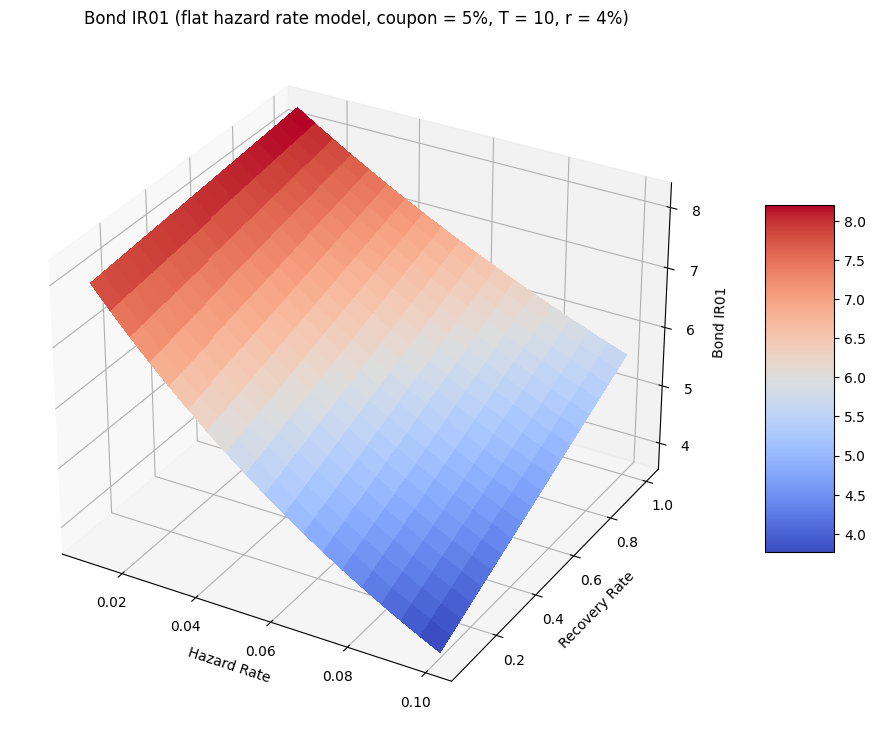

In [39]:
# Plot the IR01 surface by h and T.
for i in range(len(R_grid)):
    for j in range(len(h_grid)):
        Z[i,j] = bond_ir01_func(coupon, time_to_maturity, interest_rate, X[i,j], Y[i,j])

# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Bond IR01 (flat hazard rate model, coupon = 5%, T = 10, r = 4%)')

ax.set_xlabel('Hazard Rate')
ax.set_ylabel('Recovery Rate')
ax.set_zlabel('Bond IR01')

## e. Derive and implement the analytic formula for bond HR01 (5 points)
Use the price derivative with respect to hazard rate h to obtain the bond HR01.

Plot the HR01 surface by h and R.

In [40]:
# Use first order derivative of pv
bond_hr01_eq =  - bond_pv_eq.diff(h)
print('bond_hr01_eq:', bond_hr01_eq)
display(bond_hr01_eq)

# sample_bond_duration (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%)
bond_hr01_func = sp.lambdify([c,T,r,h,R], bond_hr01_eq)
sample_bond_hr01 = round(bond_hr01_func(0.05, 10, 0.04, 0.055, 0.40), 2)
print('Sample bond_hr01 (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%):', sample_bond_hr01)

bond_hr01_eq: -T*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1)*exp(-T*(h + r)) - (1 - exp(-T*(h + r)))*(-R*h/(h + r)**2 + R/(h + r) - c*exp(h/2 + r/2)/(4*(exp(h/2 + r/2) - 1)**2))


-T*(R*h/(h + r) + c/(2*(exp(h/2 + r/2) - 1)) - 1)*exp(-T*(h + r)) - (1 - exp(-T*(h + r)))*(-R*h/(h + r)**2 + R/(h + r) - c*exp(h/2 + r/2)/(4*(exp(h/2 + r/2) - 1)**2))

Sample bond_hr01 (for c = 5%, T = 10, r = 4%, h = 7% and R = 40%): 3.29


Text(0.5, 0, 'Bond HR01')

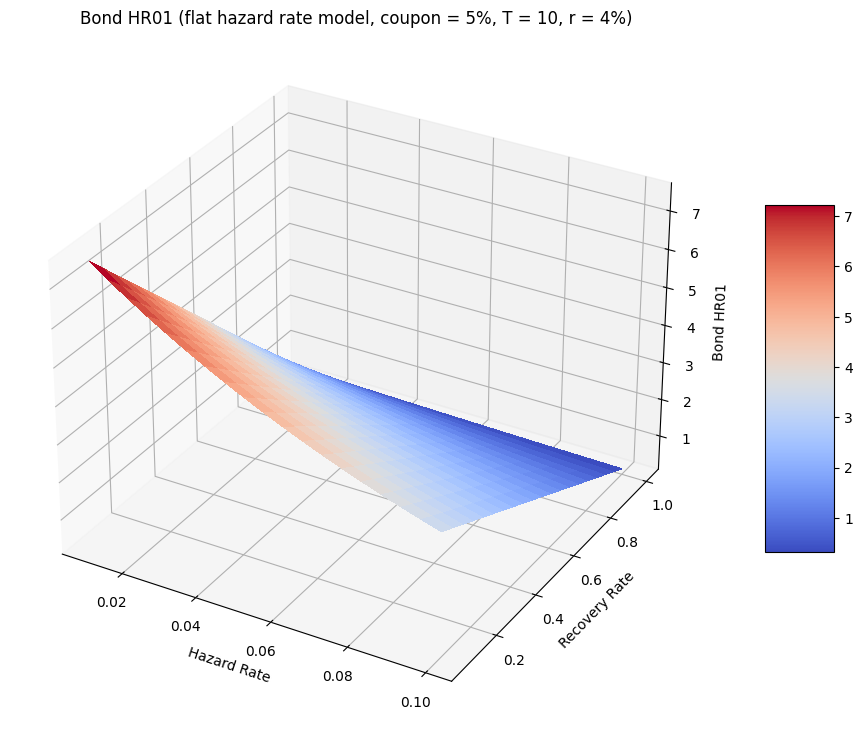

In [41]:
# Plot the HR01 surface by h and R.
for i in range(len(R_grid)):
    for j in range(len(h_grid)):
        Z[i,j] = bond_hr01_func(coupon, time_to_maturity, interest_rate, X[i,j], Y[i,j])

# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Bond HR01 (flat hazard rate model, coupon = 5%, T = 10, r = 4%)')

ax.set_xlabel('Hazard Rate')
ax.set_ylabel('Recovery Rate')
ax.set_zlabel('Bond HR01')